Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [31]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "potential_defense_midfielder"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle','shooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']


PLAYER_ATTRIBUTES = [  'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',  'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                      'StandingTackle','shooting_technique', 'SlidingTackle']



In [32]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/530288901395641231', creation_time=1702066448696, experiment_id='530288901395641231', last_update_time=1702066448696, lifecycle_stage='active', name='potential_defense_midfielder', tags={}>

### Get Data

In [33]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [34]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [35]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [36]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [37]:
df = df[(df.central == 1)&(df.offense == -0.5)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
79.0    13
76.0    12
72.0    11
78.0    11
77.0     9
73.0     9
75.0     8
71.0     7
70.0     7
80.0     6
83.0     6
69.0     6
74.0     5
84.0     5
81.0     4
86.0     3
82.0     3
68.0     3
67.0     3
89.0     2
63.0     2
64.0     2
Name: count, dtype: int64


In [38]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
241096,S. Tonali,2020,19.0,19.0,23.0,89.0,89.0,75.0,86.0,86.0,test,CDM
208141,Gabriel,2013,18.0,18.0,26.0,88.0,88.0,66.0,79.0,79.0,train,CDM
234569,Florentino,2020,19.0,19.0,23.0,87.0,87.0,76.0,80.0,80.0,test,CDM
232270,T. Fosu-Mensah,2017,18.0,18.0,20.0,87.0,87.0,71.0,76.0,76.0,train,CDM
223517,Danilo,2016,19.0,19.0,20.0,87.0,87.0,78.0,79.0,79.0,train,CDM


In [39]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [40]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Att. Position', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [41]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

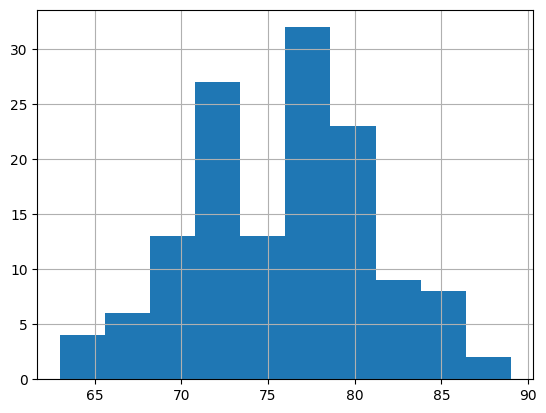

In [42]:
df['target'].hist()

In [43]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [44]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'max_potential',
       'prime_age', 'PrimeOverall', 'best_position', 'central', 'winger',
       'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [45]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


KeyError: "['shooting_technique'] not in index"

In [ ]:
y_train.describe()

count    136.000000
mean      77.102941
std        5.504583
min       63.000000
25%       73.000000
50%       78.000000
75%       80.250000
max       91.000000
Name: target, dtype: float64

In [ ]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [ ]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


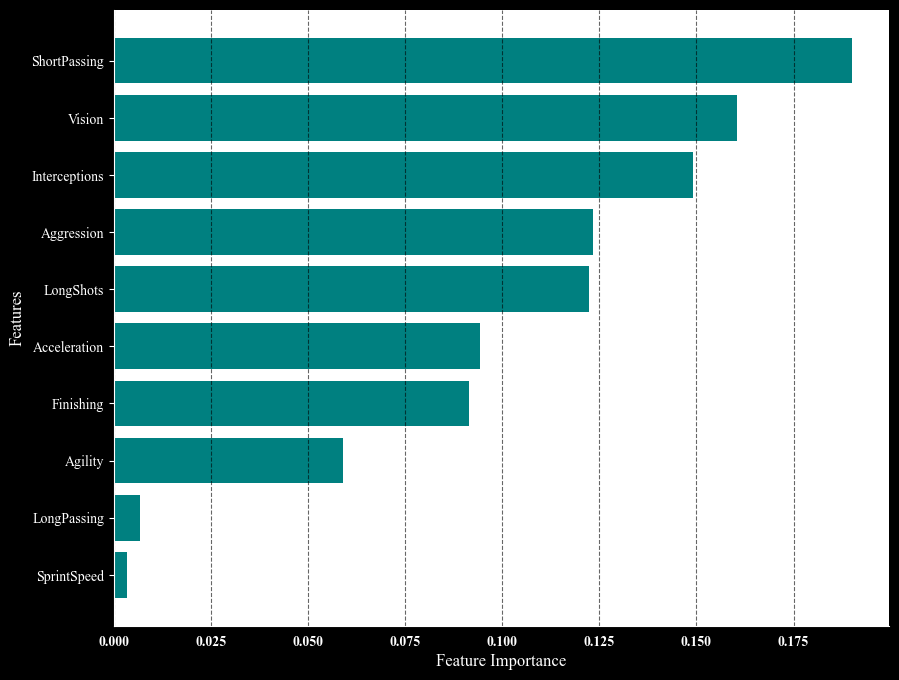

100%|██████████| 30/30 [00:05<00:00,  5.60it/s]


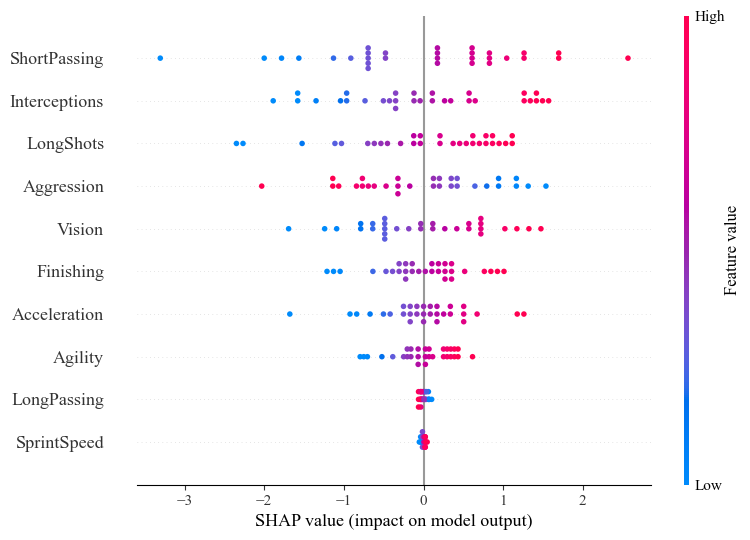

              precision    recall  f1-score   support

       False       0.96      0.93      0.94        27
        True       0.50      0.67      0.57         3

    accuracy                           0.90        30
   macro avg       0.73      0.80      0.76        30
weighted avg       0.92      0.90      0.91        30

Huber Regression training----->


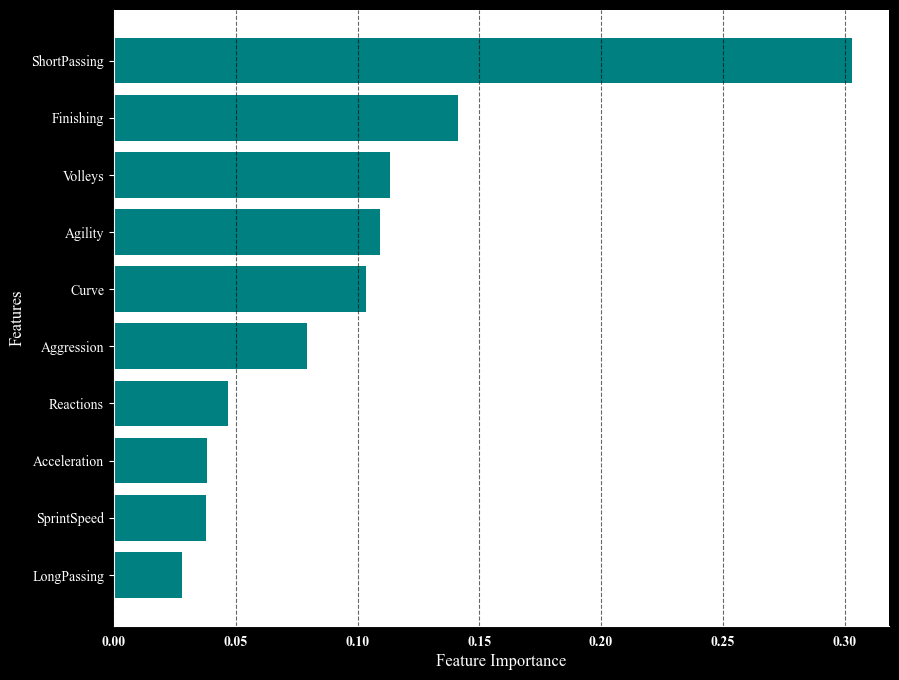

100%|██████████| 30/30 [00:04<00:00,  6.87it/s]


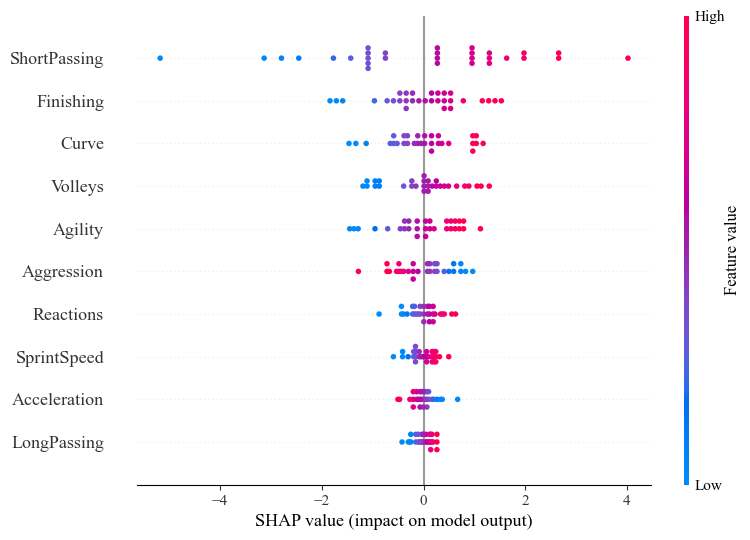

              precision    recall  f1-score   support

       False       0.96      0.93      0.94        27
        True       0.50      0.67      0.57         3

    accuracy                           0.90        30
   macro avg       0.73      0.80      0.76        30
weighted avg       0.92      0.90      0.91        30

Linear Regression training----->


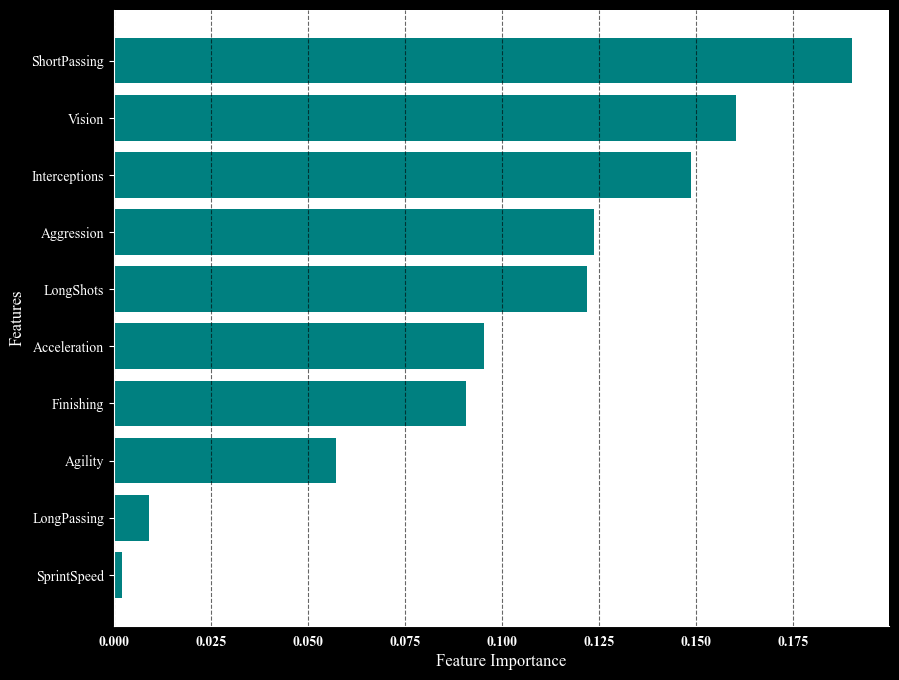

100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


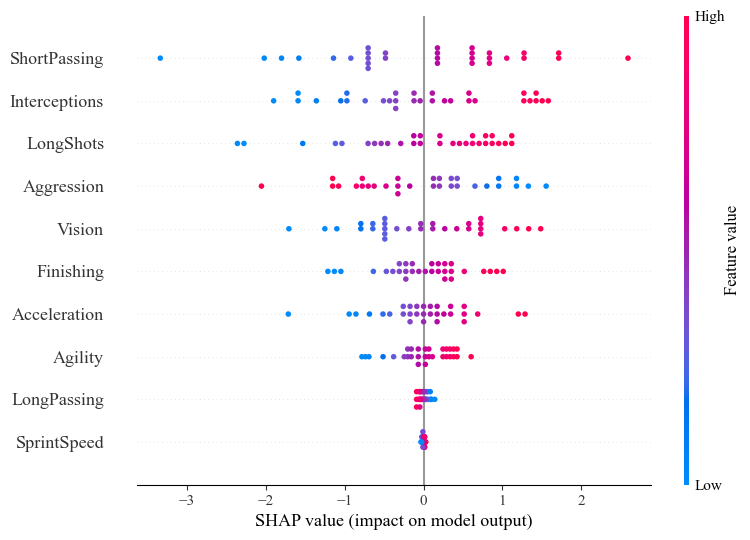

              precision    recall  f1-score   support

       False       0.96      0.93      0.94        27
        True       0.50      0.67      0.57         3

    accuracy                           0.90        30
   macro avg       0.73      0.80      0.76        30
weighted avg       0.92      0.90      0.91        30

Model: Ridge Regression
Mean Squared Error: 17.45
Mean Absolute Error: 3.36
R2 Score: 0.39

Model: Huber Regression
Mean Squared Error: 14.76
Mean Absolute Error: 2.99
R2 Score: 0.48

Model: Linear Regression
Mean Squared Error: 17.45
Mean Absolute Error: 3.36
R2 Score: 0.39



In [ ]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [ ]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [ ]:
X_train.describe()

,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Interceptions,Positioning,Vision
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,61.639706,47.580882,71.441176,57.375000,73.948529,65.397059,65.485294,73.911765,76.095588,73.779412,77.117647,64.382353,64.250000,58.992647,49.772059,62.602941,47.183824,36.176471,64.301471,69.904412
std,7.479030,9.854163,5.877471,9.344388,6.191176,10.088702,7.499121,5.822651,7.547262,6.890349,8.702540,8.423124,9.221352,9.861633,13.374917,9.986865,11.155601,13.040042,7.999370,7.153221
min,42.000000,23.000000,59.000000,31.000000,58.000000,31.000000,47.000000,60.000000,56.000000,51.000000,54.000000,43.000000,38.000000,29.000000,21.000000,34.000000,21.000000,13.000000,40.000000,49.000000
25%,56.750000,42.000000,67.000000,52.000000,70.000000,59.750000,60.000000,70.000000,71.750000,69.000000,73.000000,58.000000,58.750000,53.000000,39.750000,57.000000,39.000000,26.000000,60.000000,64.750000
50%,62.000000,48.000000,72.000000,58.000000,75.000000,65.500000,66.000000,74.000000,76.500000,75.000000,78.000000,65.000000,65.000000,59.000000,49.000000,63.500000,47.000000,33.500000,65.000000,70.000000
75%,68.000000,54.000000,75.000000,64.000000,78.000000,72.000000,71.000000,77.000000,81.000000,78.000000,83.000000,72.000000,70.250000,66.000000,60.000000,69.000000,54.250000,44.000000,69.250000,75.000000
max,77.000000,75.000000,86.000000,76.000000,92.000000,86.000000,85.000000,91.000000,94.000000,91.000000,94.000000,81.000000,86.000000,84.000000,79.000000,85.000000,80.000000,68.000000,81.000000,86.000000


In [ ]:
y_test.describe()

count    30.00000
mean     74.90000
std       5.42885
min      65.00000
25%      72.00000
50%      75.50000
75%      78.75000
max      86.00000
Name: target, dtype: float64

In [ ]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [ ]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

30

<Axes: >

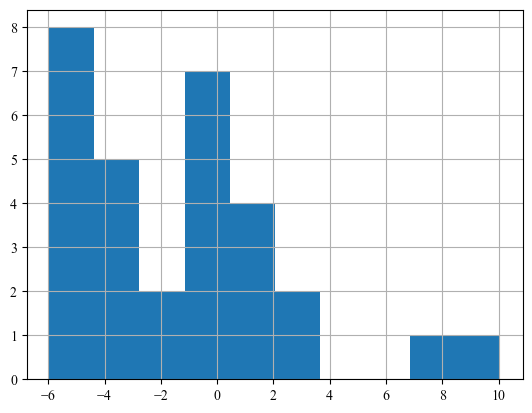

In [ ]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

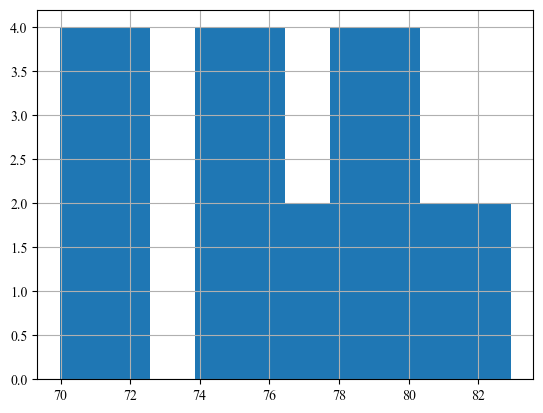

In [ ]:
result_df.sort_values(ascending=False).hist()

In [ ]:
(y_test-result_df).describe()

count    30.000000
mean     -1.217079
std       3.706527
min      -5.962297
25%      -4.386037
50%      -1.140497
75%       0.480436
max      10.054433
dtype: float64

In [ ]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Interceptions,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,
256630,F. Wirtz,2021,66.0,43.0,67.0,59.0,74.0,61.0,64.0,76.0,72.0,76.0,84.0,57.0,62.0,51.0,50.0,63.0,51.0,37.0,58.0,65.0
246863,F. Nmecha,2020,49.0,54.0,63.0,53.0,62.0,60.0,59.0,59.0,73.0,77.0,76.0,57.0,62.0,60.0,58.0,54.0,51.0,40.0,57.0,66.0


In [ ]:
y_test[outlier]

ID      Name       FIFA
256630  F. Wirtz   2021    86.0
246863  F. Nmecha  2020    78.0
Name: target, dtype: float64

In [ ]:
result_df[outlier]

ID      Name       FIFA
256630  F. Wirtz   2021    75.945567
246863  F. Nmecha  2020    71.125931
dtype: float64

In [ ]:
(y_test/result_df).describe()

count    30.000000
mean      0.983860
std       0.049822
min       0.923283
25%       0.939643
50%       0.985787
75%       1.006701
max       1.132390
dtype: float64

In [ ]:
(y_test/result_df).describe()

count    30.000000
mean      0.983860
std       0.049822
min       0.923283
25%       0.939643
50%       0.985787
75%       1.006701
max       1.132390
dtype: float64

In [ ]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.73123345],
       [0.73123345, 1.        ]])

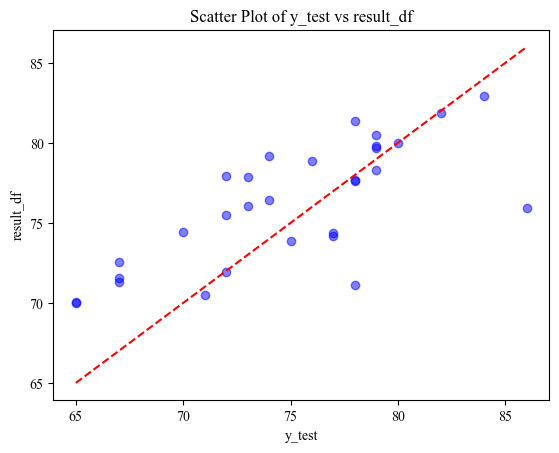

In [ ]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [ ]:
result_df = result_df.sort_values(ascending=False)

In [ ]:
result_df.head(50)

ID      Name            FIFA
237692  P. Foden        2021    82.930360
233927  Lucas Paquetá   2020    81.872904
233556  R. Orsolini     2020    81.394015
245371  T. Almada       2021    80.481589
241095  N. Vlašić       2020    79.988789
242187  C. Baumgartner  2021    79.799406
244261  L. Majer        2020    79.701375
226568  I. Hagi         2021    79.185533
234505  Evander         2021    78.900491
235008  L. Robertone    2020    78.327623
252038  Romário Baró    2020    77.962297
246419  Y. Verschaeren  2020    77.851973
240787  H. Traorè       2020    77.681211
240699  N. De la Cruz   2020    77.646971
243792  Iñigo Vicente   2020    76.408449
227978  M. Mehlem       2020    76.061702
256630  F. Wirtz        2021    75.945567
256970  A. Karabec      2021    75.492089
232669  S. Singh        2020    74.403615
246350  E. Le Fée       2021    74.385308
246960  M. Ihattaren    2020    74.208033
251570  R. Cherki       2021    73.875529
246099  K. Goudmijn     2020    72.567116
24616

In [ ]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

2


ID      Name           FIFA
237692  P. Foden       2021    82.930360
233927  Lucas Paquetá  2020    81.872904
dtype: float64

In [ ]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

2


ID      Name       FIFA
241095  N. Vlašić  2020    79.988789
256630  F. Wirtz   2021    75.945567
dtype: float64

In [ ]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

2


ID      Name         FIFA
233556  R. Orsolini  2020    81.394015
245371  T. Almada    2021    80.481589
dtype: float64

In [ ]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

24


ID      Name            FIFA
243646  B. Nygren       2020    71.333304
245340  L. Sibley       2021    71.538971
246169  Roberto López   2020    71.953011
246099  K. Goudmijn     2020    72.567116
251570  R. Cherki       2021    73.875529
246960  M. Ihattaren    2020    74.208033
246350  E. Le Fée       2021    74.385308
232669  S. Singh        2020    74.403615
256970  A. Karabec      2021    75.492089
227978  M. Mehlem       2020    76.061702
243792  Iñigo Vicente   2020    76.408449
240699  N. De la Cruz   2020    77.646971
240787  H. Traorè       2020    77.681211
246419  Y. Verschaeren  2020    77.851973
252038  Romário Baró    2020    77.962297
235008  L. Robertone    2020    78.327623
234505  Evander         2021    78.900491
226568  I. Hagi         2021    79.185533
244261  L. Majer        2020    79.701375
242187  C. Baumgartner  2021    79.799406
dtype: float64

In [ ]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.75      0.60      0.67        15
        True       0.67      0.80      0.73        15

    accuracy                           0.70        30
   macro avg       0.71      0.70      0.70        30
weighted avg       0.71      0.70      0.70        30

